# Project 1 Notebook
## Project members: Andrew, Tim, Mide

## Feel free to change/add cells as needed
## If you are going to make a function try to let each other know that you made a function so we can all use it. (Just incase)

## Points to hit:
* Point 1: Correlation between highest grossing movies and critic/user ratings
* Point 2: Correlation between the rating of a movie and the total gross
* Point 3: Correlation between movie genres and total gross
---

## Import needed packages for project
---

In [2]:
import pandas as pd
import numpy as np
import sqlite3
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='darkgrid')
%matplotlib inline

# Data cleaning work here

## IMDB Database
---

#### Extract the database

with zipfile.ZipFile('data/im.db.zip', 'r') as imdbzip:
    imdbzip.extractall('data/')

#### Connect to the database

con = sqlite3.connect('data/im.db')

#### Perform the Query to see 

imdb_df = pd.read_sql(
"""
SELECT
 movie_id,
 primary_title as title,
 averagerating,
 numvotes,
 genres,
 runtime_minutes

FROM 
 movie_ratings
 INNER JOIN movie_basics USING (movie_id)
 JOIN movie_akas USING (movie_id)
 
WHERE
 (runtime_minutes IS NOT NULL) AND (region = 'US')  AND (numvotes > 200000)

GROUP BY movie_id

ORDER BY numvotes DESC

""", con)

<img src='data/IMDBDF.jpg'>

## Movies foreign and domestic gross earnings
---

movie_gross = pd.read_csv('data/bom.movie_gross.csv')

## Rotten Tomatoes movie information
---

rt_movie_info = pd.read_csv('data/rt.movie_info.tsv', sep='\t')

## Rotten Tomatoes movie reviews
---

rt_movie_reviews = pd.read_csv('data/rt.reviews.tsv', sep='\t', encoding='latin-1')

## The Movies Database
---

tmdb_movies = pd.read_csv('data/tmdb.movies.csv', index_col=0)

## The Numbers (budget and gross)
---

tn_movie_budgets = pd.read_csv('data/tn.movie_budgets.csv')

# Creating the Master Dataframe
---

#Drop null values from Rotten Tomatoes
rt_movie_info.dropna(subset=['box_office'], inplace = True)

#Create a dataframe to clean
rt_new = rt_movie_info[['rating' , 'box_office' , 'genre', 'director']].copy()

#Cleaning the new dataframe
rt_new.dropna(subset=['director'], inplace = True)
rt_new['box_office'] = rt_new['box_office'].str.replace(',' , '')

#cast box office to type int from object
rt_new['box_office'] = rt_new['box_office'].astype(int)

#save cleaned master dataframe
rt_new.to_csv('master.csv', encoding='utf-8', index=False)

In [3]:
master = pd.read_csv('data/master.csv')
print(master.info())
master.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   rating      299 non-null    object
 1   box_office  299 non-null    int64 
 2   genre       299 non-null    object
 3   director    299 non-null    object
dtypes: int64(1), object(3)
memory usage: 9.5+ KB
None


,rating,box_office,genre,director
0,R,600000,Drama|Science Fiction and Fantasy,David Cronenberg
1,PG-13,41032915,Comedy,Jake Kasdan
2,R,224114,Drama,Ray Lawrence
3,R,134904,Drama,Taylor Hackford
4,R,1039869,Comedy|Drama|Mystery and Suspense,George Hickenlooper
5,PG-13,20518224,Action and Adventure|Drama|Science Fiction and...,Carl Erik Rinsch
6,R,1971135,Art House and International|Comedy|Drama|Music...,Jim Jarmusch
7,R,312136,Drama,John Sayles
8,R,201010,Drama,Ken Loach
9,R,54100000,Action and Adventure|Drama|Horror|Mystery and ...,James Wong


## Selecting Dataset for point 1
---

In [4]:
#creating dataframe with director and box office
d_earning = master[['director', 'box_office']]
d_earning.groupby(['director']).sum().reset_index()
d_earning.sort_values('box_office', inplace=True, ascending=False, ignore_index=True)

#create separate dataframe with top 20 earning directors
top20_d_earning = d_earning[:20]
top20_d_earning['box_office'] = top20_d_earning['box_office'].apply(lambda x: x/1000000)
top20_d_earning

<ipython-input-4-8e8912416110>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d_earning.sort_values('box_office', inplace=True, ascending=False, ignore_index=True)
<ipython-input-4-8e8912416110>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top20_d_earning['box_office'] = top20_d_earning['box_office'].apply(lambda x: x/1000000)


,director,box_office
0,Mel Gibson,368.000000
1,Peter Jackson,303.001229
2,Sam Mendes,299.300000
3,Jay Roach,279.167575
4,Chris Columbus,261.835892
5,Joel Zwick,241.250669
6,Steven Spielberg,234.141872
7,Peter Berg,227.946274
8,Bryan Singer,214.813155
9,Justin Lin,209.805005


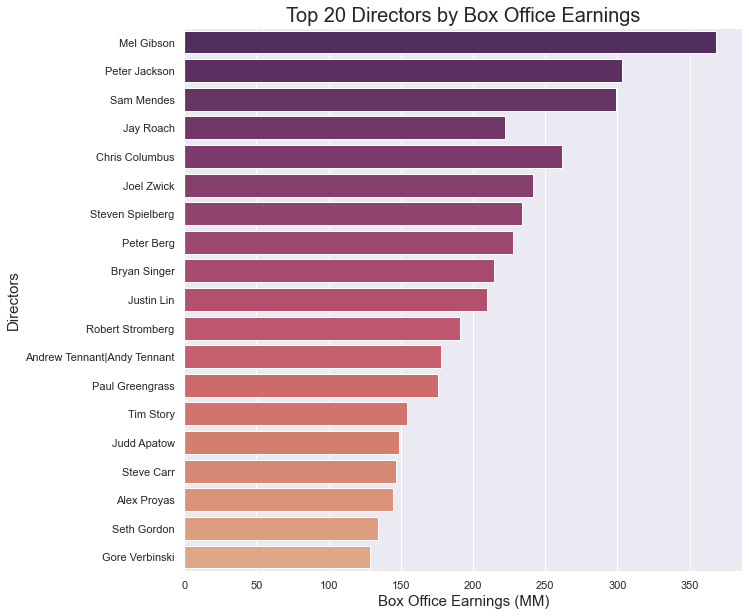

In [5]:
#create plot
fig, ax = plt.subplots(figsize=(10,10))

#plot top 20 data onto a bar plot
sns.barplot(y='director',x='box_office', orient='h', palette= 'flare_r', ci=None, data= top20_d_earning)
#setting title and labels
ax.set_title('Top 20 Directors by Box Office Earnings', fontsize=20)
ax.set_ylabel('Directors', fontsize=15)
ax.set_xlabel('Box Office Earnings (MM)', fontsize=15);

## Selected Dataset for point 2
---

### Isolate columns for my visualization

In [6]:
rating_gross = master[['rating', 'box_office']]

### Drop the irrelevant columns

In [7]:
rating_gross.drop(rating_gross[rating_gross['rating'] == 'NR'].index, inplace=True)
rating_gross.drop(rating_gross[rating_gross['rating'] == 'NC17'].index, inplace=True)
rating_gross.drop(rating_gross[rating_gross['rating'] == 'G'].index, inplace=True)

/Users/olamideholayinka/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


### Visualize

/Users/olamideholayinka/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 13.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


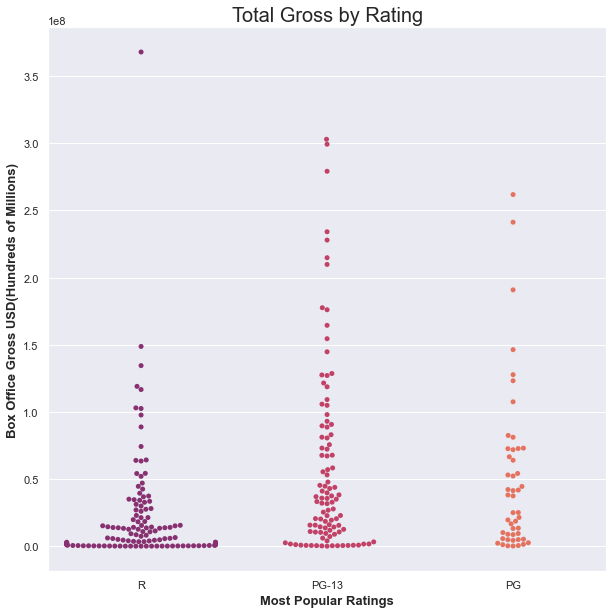

In [8]:
sns.set_theme(style="darkgrid")

f, ax = plt.subplots(figsize=(10, 10))


sns.swarmplot(x="rating", y="box_office", data=rating_gross, palette= 'flare_r')
plt.yticks
ax.set_xlabel('Most Popular Ratings', fontsize = 13, weight = 'bold')
ax.set_ylabel('Box Office Gross USD(Hundreds of Millions)', fontsize = 13, weight = 'bold')
ax.set_title('Total Gross by Rating', fontsize = 20);

## Selecting Dataset for point 3
---

In [ ]:
# Filtering down dataset to top 20 

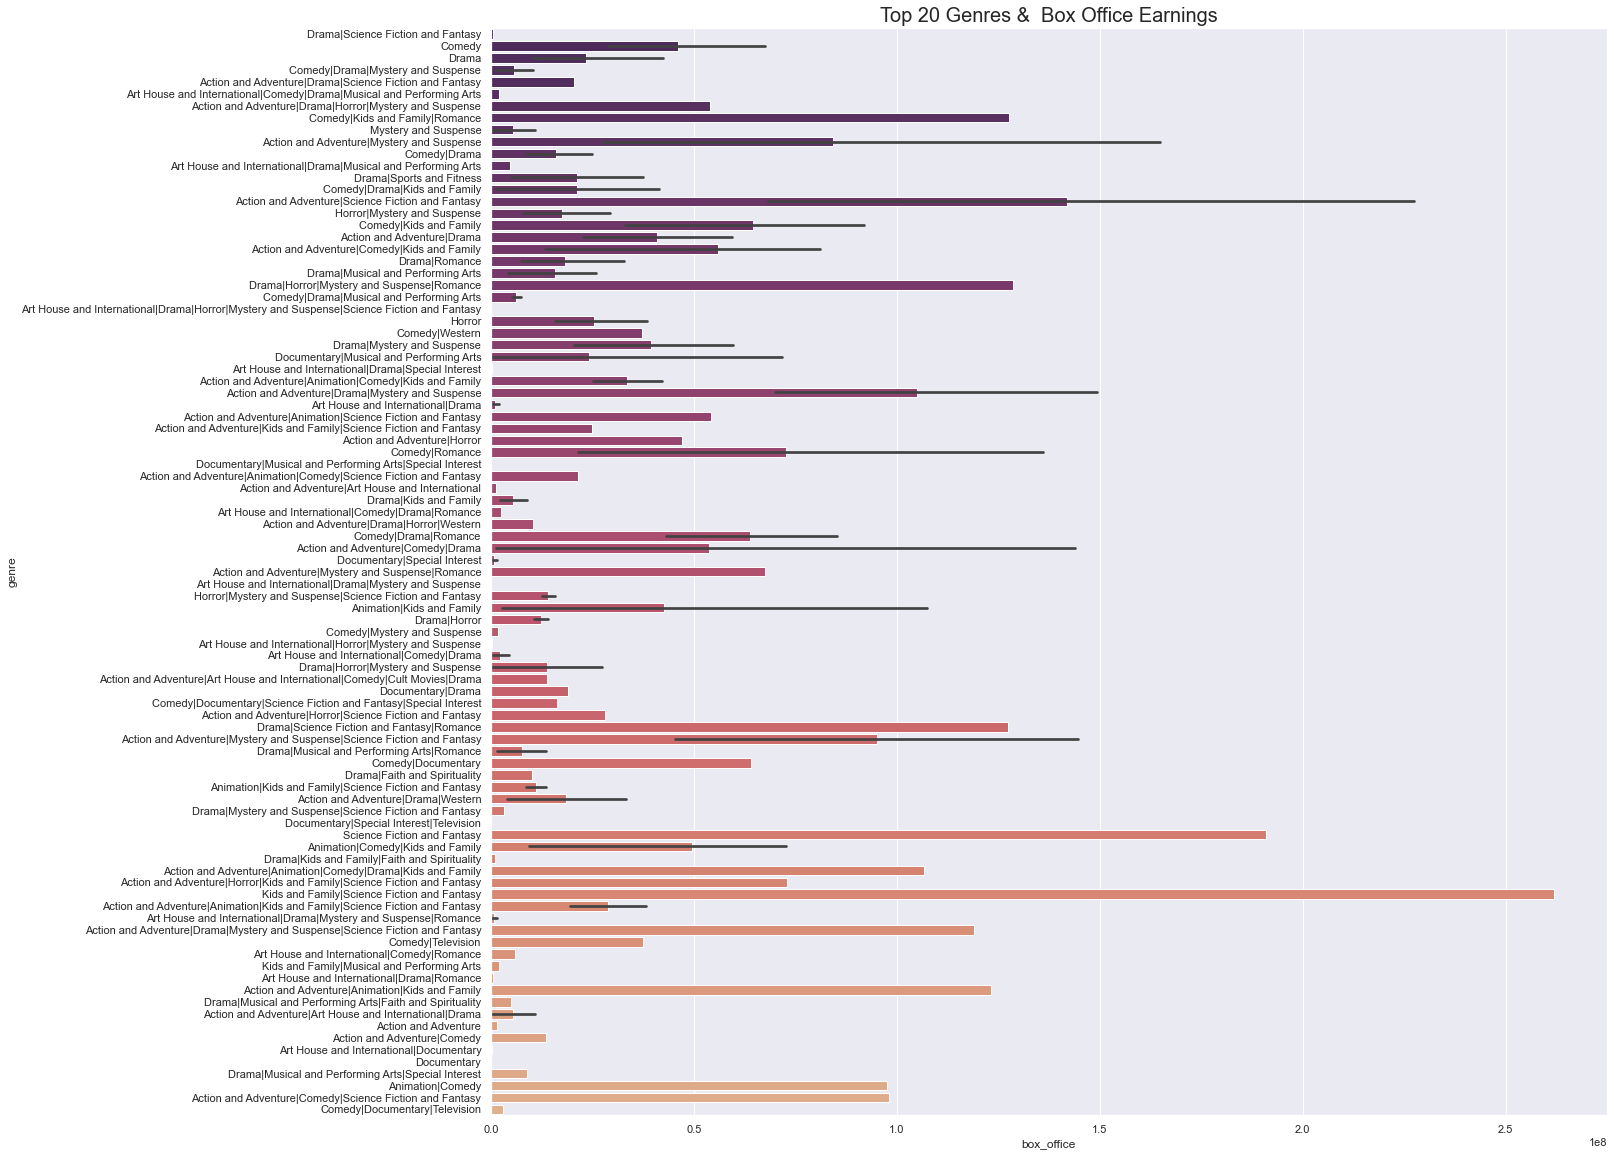

In [17]:
#Creating a Vizualization for relationship between Genre and Box Office

fig, ax = plt.subplots(figsize=(20,20))
ax.set_title('Top 20 Genres &  Box Office Earnings', fontdict={'fontsize': 20})
sns.barplot(y='genre',x='box_office', orient='h',  palette= 'flare_r',data= master);